In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import os
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [6]:
joke = pd.read_csv('/home/lanayawiz/main/concept-tree/final/jokes_statistics_CONSOLIDATED.csv')
sentence = pd.read_csv('/home/lanayawiz/main/concept-tree/final/sentence_statistics_CONSOLIDATED.csv')

In [7]:
joke['is_joke'] = 1
sentence['is_joke'] = 0

In [8]:
df = pd.concat([joke, sentence])
df = df.drop(['joke_id', 'sentence_id', 'item_text', 'subgraph_components', 'subgraph_diameter', 'mean_eigenvector_centrality_subgraph'], axis=1)

In [9]:
tokeep = [
    "is_joke",
    "proportion_unique_relation_types",
    "ratio_ROOT_to_cc",
    "ratio_ROOT_to_obl",
    "ratio_ROOT_to_amod",
    "bridging_relation_ratio",
    "concept_contrast",
    "ratio_core_modifying_relations",
    "ratio_ROOT_to_nsubj",
    "ratio_cc_to_orphan",
    "ratio_ROOT_to_advmod",
    "ratio_ROOT_to_conj",
    "ratio_ROOT_to_parataxis",
    "mean_centrality_bridging_concepts_betweenness",
    "ratio_ROOT_to_nmod",
    "joke_nodes_mean_bg_betweenness_centrality",
    "community_count",
    "ratio_obl_to_amod",
    "dependency_label_entropy",
    "ratio_ROOT_to_obj",
    "joke_nodes_mean_bg_closeness_centrality"
]

In [10]:
#df = df[tokeep]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 676517 entries, 0 to 335656
Columns: 261 entries, subgraph_avg_degree to is_joke
dtypes: float64(251), int64(10)
memory usage: 1.3 GB


In [12]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'is_joke' in numeric_cols:
    numeric_cols.remove('is_joke')

In [13]:
cols_to_drop_zero_variance = []

print("\nПроверка признаков на нулевую дисперсию:")
for col in numeric_cols:
    data = df[col].dropna() 
    if len(data) <= 1:
        print(f"  - Признак '{col}': Менее 2 не-NaN значений ({len(data)}). Будет удален.")
        cols_to_drop_zero_variance.append(col)
    else:
        std_dev = data.std()
        if std_dev == 0:
            print(f"  - Признак '{col}': Стандартное отклонение равно 0. Все значения одинаковы. Будет удален.")
            cols_to_drop_zero_variance.append(col)
            
print(f"\nНайдено {len(cols_to_drop_zero_variance)} признаков с нулевой дисперсией для удаления.")
print(f"Признаки с нулевой дисперсией: {cols_to_drop_zero_variance}")

df = df.drop(columns=cols_to_drop_zero_variance)


Проверка признаков на нулевую дисперсию:

Найдено 0 признаков с нулевой дисперсией для удаления.
Признаки с нулевой дисперсией: []


In [14]:
X = df.drop('is_joke', axis=1)
y = df['is_joke']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [16]:
median_degree_assortativity_train = X_train['degree_assortativity_subgraph'].median()

X_train['degree_assortativity_subgraph'].fillna(median_degree_assortativity_train, inplace=True)
X_test['degree_assortativity_subgraph'].fillna(median_degree_assortativity_train, inplace=True) 

print("\nПропущенные значения после импутации в X_train:\n", X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("Пропущенные значения после импутации в X_test:\n", X_test.isnull().sum()[X_test.isnull().sum() > 0])

/tmp/ipykernel_301500/3162093973.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['degree_assortativity_subgraph'].fillna(median_degree_assortativity_train, inplace=True)
/tmp/ipykernel_301500/3162093973.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh


Пропущенные значения после импутации в X_train:
 Series([], dtype: int64)
Пропущенные значения после импутации в X_test:
 Series([], dtype: int64)


In [17]:
'''from scipy.stats import skew

SKEWNESS_THRESHOLD = 1.0
log1p_columns = []
feature_cols_for_skew = X_train.select_dtypes(include=np.number).columns.tolist()

print(f"\nПроверка асимметрии и применение log1p при skewness > {SKEWNESS_THRESHOLD}:")

for col in feature_cols_for_skew:
    data_train = X_train[col].dropna() #
    
    if len(data_train) > 1:
        try:
            current_skew_train = skew(data_train)
            
            if abs(current_skew_train) > SKEWNESS_THRESHOLD:
                if (X_train[col] < 0).any():
                    print(f"Колонка '{col}' содержит отрицательные значения, но имеет сильную асимметрию ({current_skew_train:.2f}). log1p может быть не лучшим выбором.")
                else:
                    log1p_columns.append(col)
                    X_train[col] = np.log1p(X_train[col])
                    X_test[col] = np.log1p(X_test[col])
                    print(f"  - Признак '{col}': Асимметрия = {current_skew_train:.2f}. Применено log1p преобразование.")
                    
        except Exception as e:
            print(f"  - Признак '{col}': Не удалось рассчитать асимметрию ({e}). Пропускаем log1p.")

print(f"\nСписок колонок, к которым применено log1p: {log1p_columns}")'''


'from scipy.stats import skew\n\nSKEWNESS_THRESHOLD = 1.0\nlog1p_columns = []\nfeature_cols_for_skew = X_train.select_dtypes(include=np.number).columns.tolist()\n\nprint(f"\nПроверка асимметрии и применение log1p при skewness > {SKEWNESS_THRESHOLD}:")\n\nfor col in feature_cols_for_skew:\n    data_train = X_train[col].dropna() #\n    \n    if len(data_train) > 1:\n        try:\n            current_skew_train = skew(data_train)\n            \n            if abs(current_skew_train) > SKEWNESS_THRESHOLD:\n                if (X_train[col] < 0).any():\n                    print(f"Колонка \'{col}\' содержит отрицательные значения, но имеет сильную асимметрию ({current_skew_train:.2f}). log1p может быть не лучшим выбором.")\n                else:\n                    log1p_columns.append(col)\n                    X_train[col] = np.log1p(X_train[col])\n                    X_test[col] = np.log1p(X_test[col])\n                    print(f"  - Признак \'{col}\': Асимметрия = {current_skew_train:.2

In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

model = HistGradientBoostingClassifier(random_state=42, n_iter_no_change=5, max_iter=200)
model.fit(X_train, y_train)

print("\nОценка производительности модели:")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)


Оценка производительности модели:


In [19]:
print(f"\nОценка модели на тестовой выборке:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  ROC AUC: {roc_auc:.4f}")


Оценка модели на тестовой выборке:
  Accuracy: 0.8210
  Precision: 0.8611
  Recall: 0.7687
  F1-Score: 0.8123
  ROC AUC: 0.9031


Shape of full shap_values matrix right before shap.summary_plot: (169130, 260)


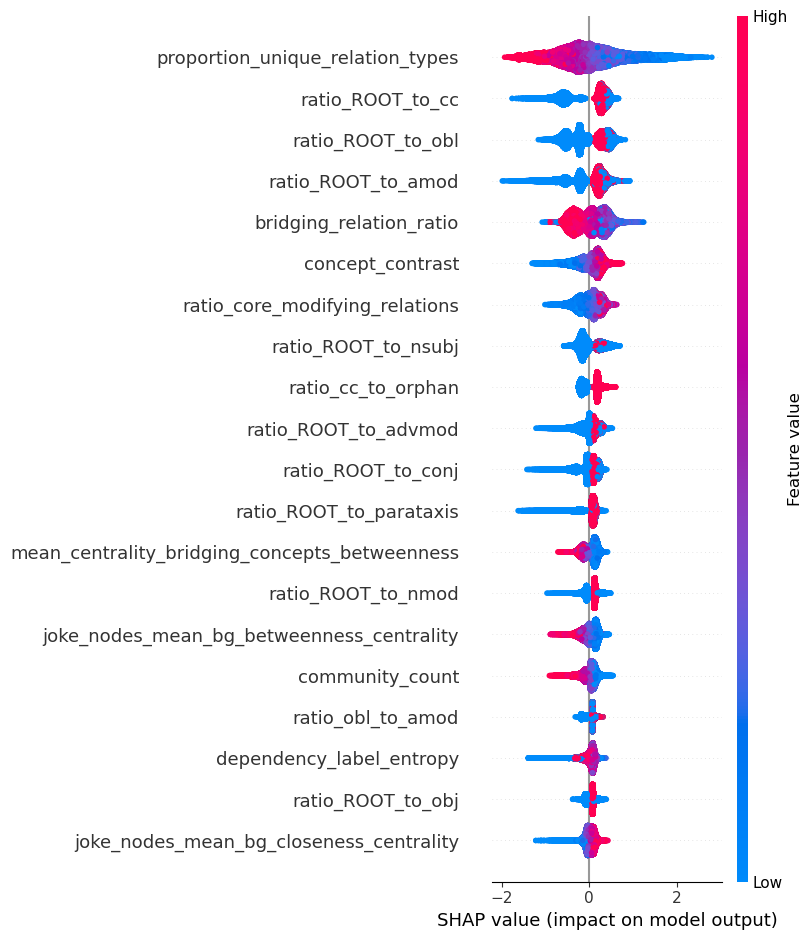

In [20]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

print(f"Shape of full shap_values matrix right before shap.summary_plot: {shap_values.shape}")

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

plt.show()

In [45]:
jokes_llm = pd.read_csv('/home/lanayawiz/main/concept-tree/final/jokes_statistics_CONSOLIDATED_LLM.csv')
sentences_llm = pd.read_csv('/home/lanayawiz/main/concept-tree/final/sentence_statistics_CONSOLIDATED_LLM.csv')

In [46]:
jokes_llm['is_joke'] = 1
sentences_llm['is_joke'] = 0

df_llm = pd.concat([jokes_llm, sentences_llm])
df_llm = df_llm .drop(['joke_id', 'sentence_id', 'subgraph_components', 'subgraph_diameter', 'mean_eigenvector_centrality_subgraph'], axis=1)

df_llm['degree_assortativity_subgraph'].fillna(median_degree_assortativity_train, inplace=True)

/tmp/ipykernel_301500/4223126764.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_llm['degree_assortativity_subgraph'].fillna(median_degree_assortativity_train, inplace=True)


In [47]:
X_llm = df_llm[list(X_test.columns.values)]
y_llm = df_llm['is_joke']

texts_llm = df_llm['item_text']

In [48]:
y_pred = model.predict(X_llm)
y_pred_proba = model.predict_proba(X_llm)[:, 1] 

accuracy = accuracy_score(y_llm, y_pred)
precision = precision_score(y_llm, y_pred)
recall = recall_score(y_llm, y_pred)
f1 = f1_score(y_llm, y_pred)
roc_auc = roc_auc_score(y_llm, y_pred_proba)

In [49]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8948
Precision: 0.9689
Recall: 0.8155
F1-score: 0.8856
ROC-AUC: 0.9466


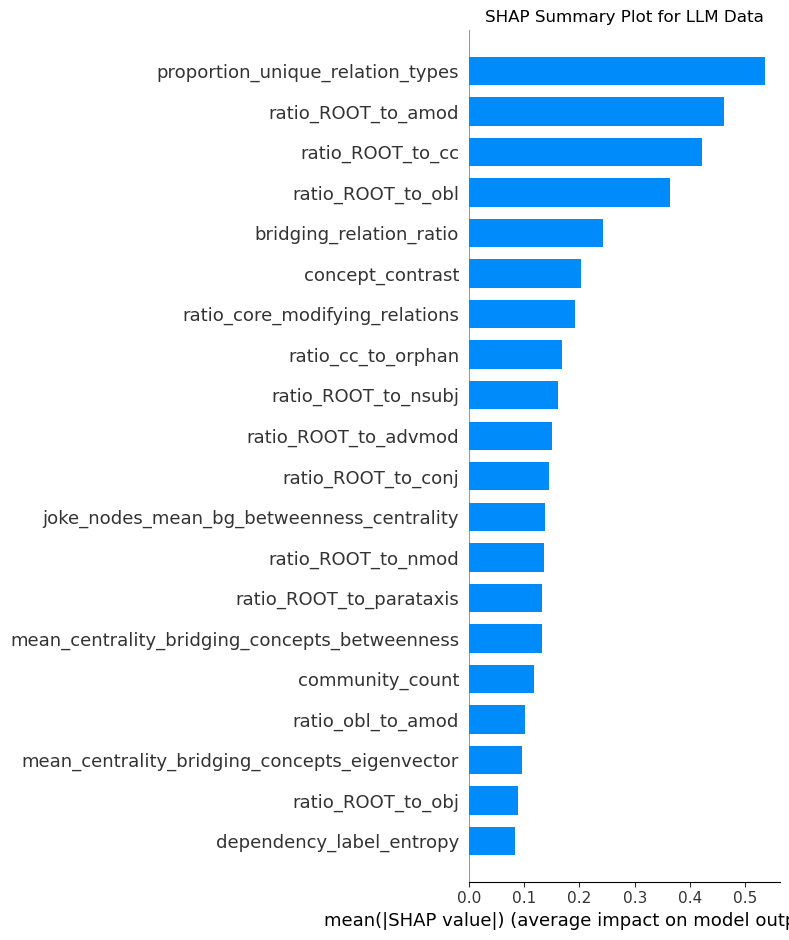

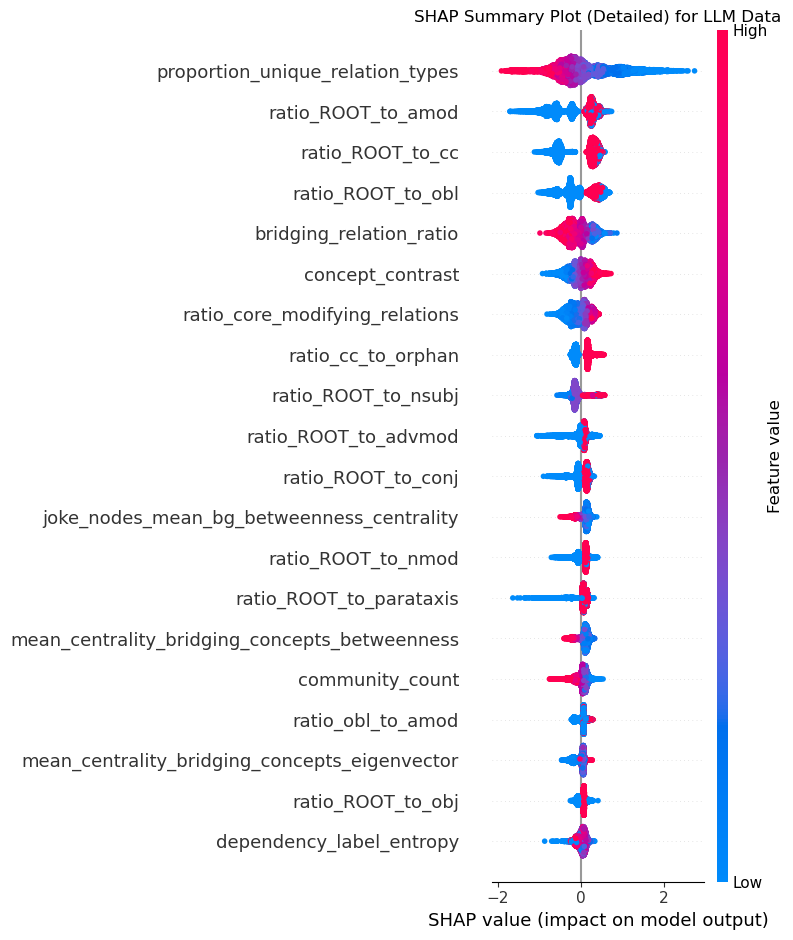

In [50]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_llm)

shap.summary_plot(shap_values, X_llm, plot_type="bar", show=False)
plt.title("SHAP Summary Plot for LLM Data")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_llm, show=False)
plt.title("SHAP Summary Plot (Detailed) for LLM Data")
plt.tight_layout()
plt.show()

In [61]:
results_df = pd.DataFrame({
    'true_label': y_llm,
    'predicted_label': y_pred,
    'text': texts_llm
})

results_df_shuffled = results_df.sample(frac=1, random_state=None).reset_index(drop=True)

true_positives = results_df_shuffled[(results_df_shuffled['true_label'] == 1) & (results_df_shuffled['predicted_label'] == 1)].head(5)
true_negatives = results_df_shuffled[(results_df_shuffled['true_label'] == 0) & (results_df_shuffled['predicted_label'] == 0)].head(5)
false_positives = results_df_shuffled[(results_df_shuffled['true_label'] == 0) & (results_df_shuffled['predicted_label'] == 1)].head(5)
false_negatives = results_df_shuffled[(results_df_shuffled['true_label'] == 1) & (results_df_shuffled['predicted_label'] == 0)].head(5)

In [62]:
print("\n=== Положительно классифицированные (True Positives) ===")
for idx, row in true_positives.iterrows():
    print(f"Текст: {row['text']}")


=== Положительно классифицированные (True Positives) ===
Текст: Жена спрашивает мужа: – Дорогой, ты знаешь, что я сегодня почувствовала? – Радость? – Нет, грусть. Я потеряла ключи от машины.
Текст: Почему гора не любит ходить на вечеринки? Потому что у неё всегда в голове только подъем.
Текст: – Почему день всегда опаздывает? – Потому что он все время потрачен на то, чтобы провести со мной!
Текст: — Почему страх такой плохой танцор? — Потому что он постоянно застывает на месте.
Текст: Встречаются два динамика. Один спрашивает другого: "Ты слышал новую песню?" – "Слышал, но она просто не мой формат."


In [63]:
print("\n=== Отрицательно классифицированные (True Negatives) ===")
for idx, row in true_negatives.iterrows():
    print(f"Текст: {row['text']}")


=== Отрицательно классифицированные (True Negatives) ===
Текст: В ночной тишине, словно тень, крался могучий зверь, обладая хищным блеском в его желтых глазах.
Текст: Яркий луч лампы освещал старинную книгу, лежащую на столе в тишине комнаты.
Текст: В глубине его сочувствующего взгляда отражалось все безграничное море моей собственной боли и беспомощности.
Текст: Мощный удар, словно разрядившаяся молния, отрезвил противника, заставив отступить в замешательстве.
Текст: Едва понюхав новую кожаную обувь, я почувствовал, как она станет верным спутником в долгих путешествиях.


In [64]:
print("\n=== Ложноположительные (False Positives) ===")
for idx, row in false_positives.iterrows():
    print(f"Текст: {row['text']}")


=== Ложноположительные (False Positives) ===
Текст: Тяжелая, словно пелена, пыль застилала окна старинного дома, храня воспоминания о давно ушедших временах.
Текст: Нежный смех маленького ребенка заполнил комнату, когда он строил башню из кубиков.
Текст: Темнота сгущалась, затягивая все вокруг в беспросветную, тихую и загадочную ночную мглу.
Текст: Его мощный форхенд, не оставляющий шансов противнику, принес ему блиц-победу в третьем сете.
Текст: Ожерелье из жемчуга, мерцая в лучах солнца, добавляло элегантности и изысканности ее образу.


In [65]:
print("\n=== Ложноотрицательные (False Negatives) ===")
for idx, row in false_negatives.iterrows():
    print(f"Текст: {row['text']}")


=== Ложноотрицательные (False Negatives) ===
Текст: – Почему летом так много людей потеют? – Потому что жарко, и им нечем было пахать.
Текст: — Почему время такое скучное? — Потому что оно всегда идет вперед, а у тебя нет выбора.
Текст: Встретились два барана и оба сказали: "Ой, как же я люблю тебя!"
Текст: — Почему сомнение такое сложно? — Потому что оно постоянно спрашивает: "А что, если?"
Текст: — Почему тьма всегда так тихо? — Потому что она не хочет, чтобы ее слышали, когда она пытается тебя съесть.
